<font size="4">In this notebook we will create a synthetic image dataset via normalising flows</font>
- To begin with, we define a simple base distribution, in our case a 2-D Gaussian
- Define a few bijectors, which will be chained up together to make a custom normalising flow
- Apply the flow to our base distribution to obtain a transformed distribution
- Draw samples from this distribution and construct the image array
- Construct nicely formatted train and test dataset


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


The normalising flow construction procedures:
* To construct the image dataset, first build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.5$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[1, 2\pi)$
  * $a \sim N(2, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.


Define the distributions for our parameters as specified above

In [3]:
theta_distribution = tfd.Uniform(low = 1, high = 2*np.pi)
a_distribution = tfd.Normal(loc = 2, scale =1)

Define our base 2D Gaussian distribution

In [4]:
def base_2d_gaussian(mu=0,sigma=0.5):
    return tfd.MultivariateNormalDiag(
            loc = [mu,mu],
            scale_diag = [sigma,sigma]
    
    )

Plot a few samples from the base distribution

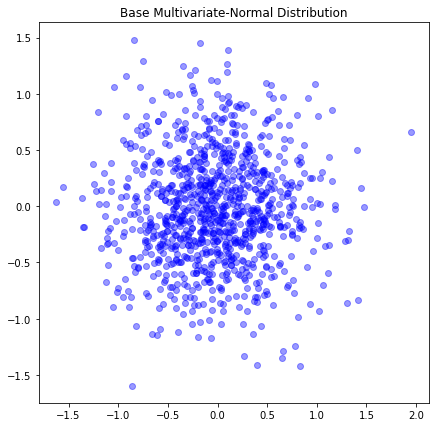

In [5]:
# Plot a few samples
base_2d = base_2d_gaussian().sample(1000).numpy().squeeze()
plt.figure(figsize=(7,7))
plt.scatter(base_2d[:,0],base_2d[:,1],color='blue',alpha=0.4)
plt.title('Base Multivariate-Normal Distribution')
plt.show()

Define the bijector _f3_

In [6]:
class Scaled_square(tfb.Bijector):
    def __init__(self,a,validate_args = False, name = 'Scaled_square'):
        super().__init__(
                validate_args = validate_args,
                forward_min_event_ndims=1,
                name = name,
                is_constant_jacobian=True
        
        )
        
        self.a = tf.cast(a, dtype=tf.float32)
    def _forward(self,x):
        x = tf.cast(x,tf.float32)
        return tf.concat([x[...,0:1],
                          x[...,1:] + self.a * tf.square(x[...,0:1])],axis=-1)
    
    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.concat([y[..., 0:1], 
                          y[..., 1:] - self.a * tf.square(y[..., 0:1])], axis=-1)
        
    def _forward_log_det_jacobian(self, x):
        return tf.constant(1., dtype=x.dtype)
    

Define the _Rotation_ bijector

In [12]:
class Rotation(tfb.Bijector):
    def __init__(self, theta, name="Rotation"):
        super(Rotation, self).__init__(name=name, 
                                       forward_min_event_ndims=1, 
                                       validate_args=False, 
                                       )
        
        self.rotation_matrix = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)], 
                                                [tf.sin(theta), tf.cos(theta)]], dtype=tf.float32)

    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.linalg.matvec(self.rotation_matrix, x)

    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.linalg.matvec(tf.transpose(self.rotation_matrix), y)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(1., dtype=x.dtype)

Build the flow

In [13]:
def flow(a,theta):
    f1 = tfb.Shift([0,-2])
    f2 = tfb.Scale([1,0.5])
    f3 = Scaled_square(a)
    f4 = Rotation(theta)
    f5 = tfb.Tanh()
    return tfb.Chain([f5,f4,f3,f2,f1])

In [14]:
def get_transformed_distribution(base_distribution,bijector):
    transformed_dist = tfd.TransformedDistribution(distribution = base_distribution,
                                                   bijector = bijector)
    return transformed_dist

In [17]:
def plot_flows(theta, a, flow, n_samples, color="black"):
    samples = flow.sample(n_samples).numpy().squeeze()
    plt.scatter(samples[:,0], samples[:, 1], color=color, alpha=0.6)
    plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
    plt.xlim([-1,1])
    plt.ylim([-1,1])

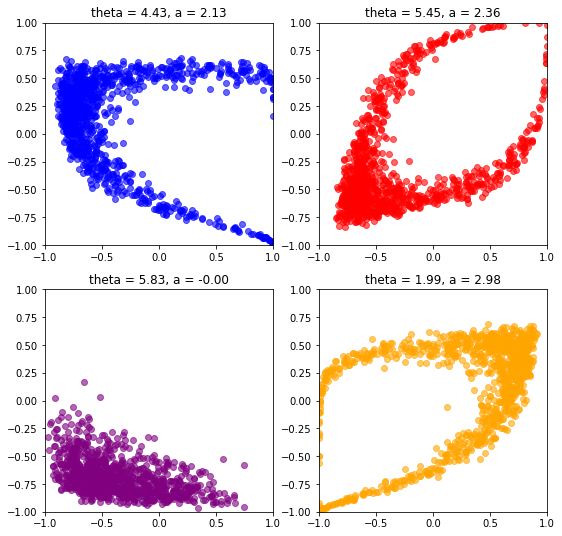

In [18]:
n=1000
base = base_2d_gaussian()
plt.figure(figsize = (9,9))
for position, color in enumerate(['blue','red','purple','orange']):
    theta = theta_distribution.sample(1).numpy()[0]
    a = a_distribution.sample(1).numpy()[0]
    my_flow = get_transformed_distribution(base,bijector = flow(a,theta))
    plt.subplot(2,2,position+1)
    plot_flows(theta,a,my_flow,n,color)
plt.show()

Define a function to return density distribution from input (batched) distribution object

In [20]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a batched Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, this can be used to make a 
    contour plot with the following code:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [21]:
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

Generate a contour plot for a few image samples

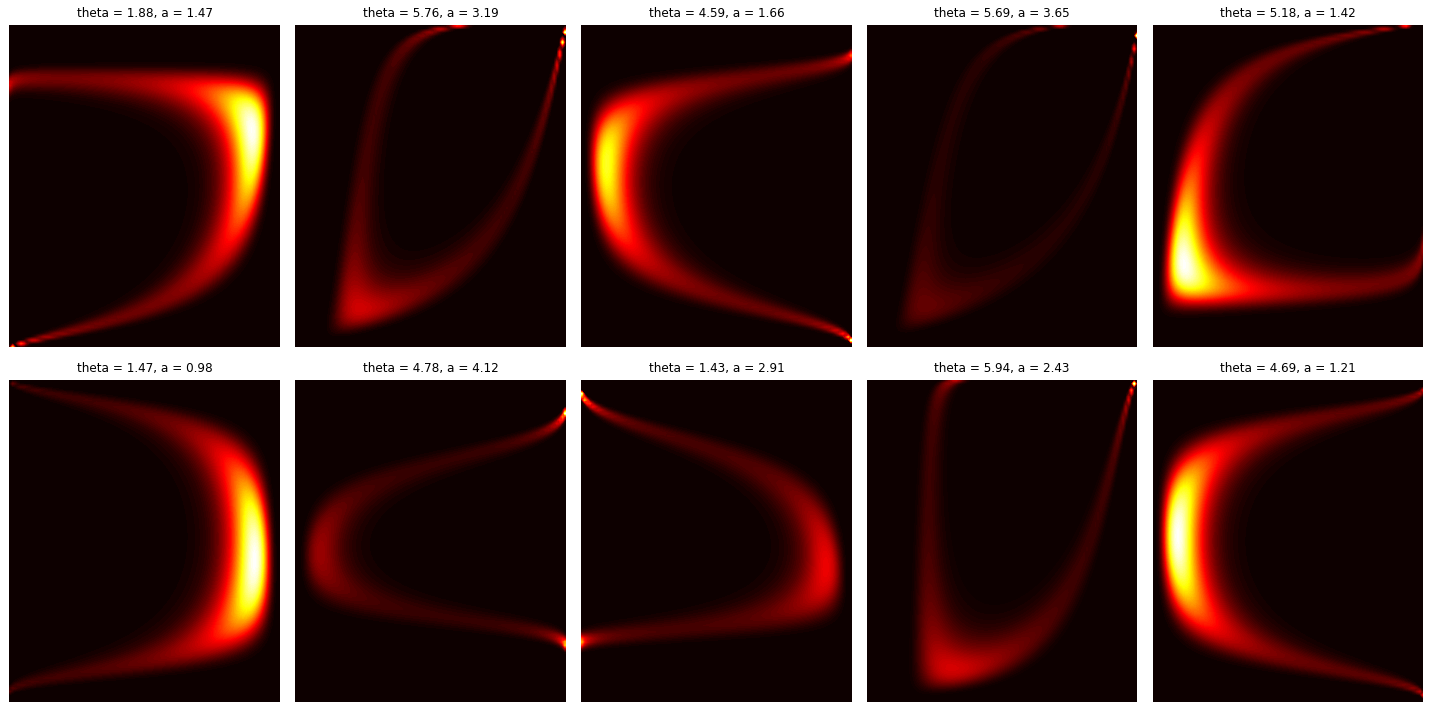

In [30]:
plt.figure(figsize = (20, 10))
for i in range(10):
    # Parameter Sampling
    theta = theta_distribution.sample(1).numpy()[0]
    a = a_distribution.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist =  get_transformed_distribution(base,bijector = flow(a,theta))
    flow_dist = tfd.BatchReshape(flow_dist, [1])
    # Contour Plot
    plt.subplot(2, 5, i+1)
    plt.contourf(X, Y, get_densities(flow_dist).squeeze(), cmap='hot', levels=100)
    plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
    plt.axis('off')
plt.tight_layout()
plt.show()

Generate _2000_ images from the transformed distribution

In [26]:
images = []

N = 2000

for _ in range(N):
    # Parameter Sampling
    theta = theta_distribution.sample(1).numpy()[0]
    a = a_distribution.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist =  get_transformed_distribution(base,bijector = flow(a,theta))
    flow_dist = tfd.BatchReshape(flow_dist, [1])
    # Getting Density
    Z = get_densities(flow_dist).squeeze()
    #Saving Images
    images.append(get_image_array_from_density_values(Z))

images = np.array(images)

Plot a few random samples

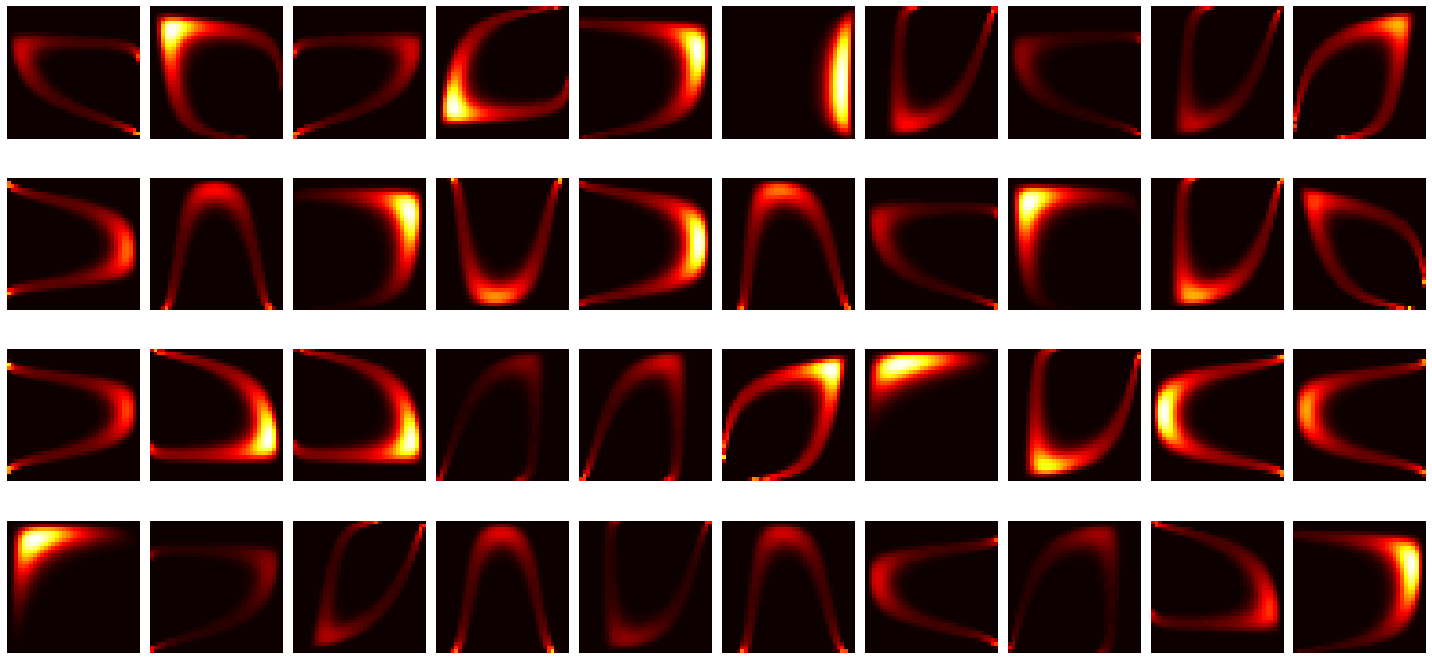

In [31]:
plt.figure(figsize=(20, 10))
for i in range(40):
    plt.subplot(4, 10, i+1)
    idx = np.random.randint(0, N)
    plt.imshow(images[idx])
    plt.axis("off")
plt.tight_layout()
plt.show()


Define functions for train-test data split

In [33]:
def train_test_split(data,split):
    data = data.astype(dtype=np.float32)
    N = data.shape[0]
    train_idx = np.random.choice(np.arange(N),size = int(split*N))
    test_idx = np.setdiff1d(np.arange(N),train_idx)
    return data[train_idx],data[test_idx]

In [34]:
def get_dataset(data,test_ratio,batch_size=20):
    train,test = train_test_split(data,test_ratio)
    
    train = tf.data.Dataset.from_tensor_slices(train)
    # normalise the pixel value
    train = train.map(lambda x: x/255)
    # return a tuple of (input,input)
    train = train.map(lambda x: (x,x))
    train = train.batch(batch_size,drop_remainder=True)
    
    test = tf.data.Dataset.from_tensor_slices(test)
    # normalise the pixel value
    test = test.map(lambda x: x/255)
    # return a tuple of (input,input)
    test = test.map(lambda x: (x,x))
    test = test.batch(batch_size,drop_remainder=True)
    
    return train, test

Make dataset with batch size = 10 

In [36]:
batch_size = 10
train_data,test_data = get_dataset(images,0.3,batch_size = batch_size)

print(train_data.element_spec)
print(test_data.element_spec)

(TensorSpec(shape=(10, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(10, 36, 36, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(10, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(10, 36, 36, 3), dtype=tf.float32, name=None))
